# 04 — DBSCAN + k-distance plot
Cél: sűrűség-alapú klaszterezés kipróbálása (tetszőleges alakú klaszterek), 
`eps` és `min_samples` hangolása k-distance görbével. 
Metrikák: silhouette, DB, CH. Eredmények CSV-be mentve.


In [29]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from src.datasets import make_all_datasets
from src.evaluation import evaluate
from src.visualization import pca_scatter

# DBSCAN-hez csak 3 dataset-et használunk (blobs, moons, circles)
datasets_full = make_all_datasets()
datasets = {k: v for k, v in datasets_full.items() if k in ["blobs", "moons", "circles"]}
list(datasets.keys())

['blobs', 'moons', 'circles']

In [30]:
def k_distance_plot(X, k=4, title="k-distance plot"):
    Xs = StandardScaler().fit_transform(X)
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(Xs)
    dists, _ = nn.kneighbors(Xs)
    kdist = np.sort(dists[:, -1])
    plt.figure(figsize=(6,3.5))
    plt.plot(kdist)
    plt.title(f"{title} (k={k})"); plt.xlabel("sorted samples"); plt.ylabel(f"{k}-NN distance")
    plt.tight_layout(); plt.show()
    return kdist  # a "könyök" környéke jó eps tipp


In [31]:
def dbscan_sweep(X, eps_values, min_samples_values=(3,5,10)):
    Xs = StandardScaler().fit_transform(X)
    rows = []
    for eps in eps_values:
        for ms in min_samples_values:
            labels = DBSCAN(eps=float(eps), min_samples=int(ms)).fit_predict(Xs)
            m = evaluate(Xs, labels)  # {'sil','db','ch'}  (ha minden -1, sil NaN lesz)
            rows.append({"eps": float(eps), "min_samples": int(ms), **m})
    return pd.DataFrame(rows)

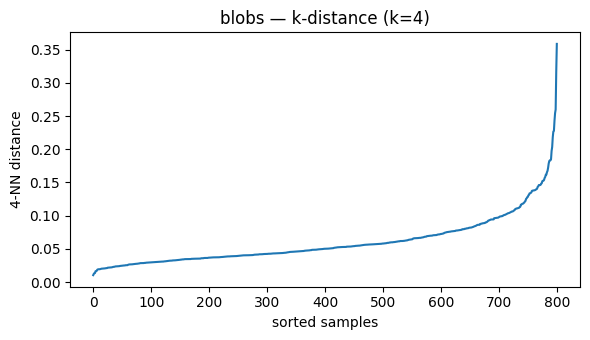

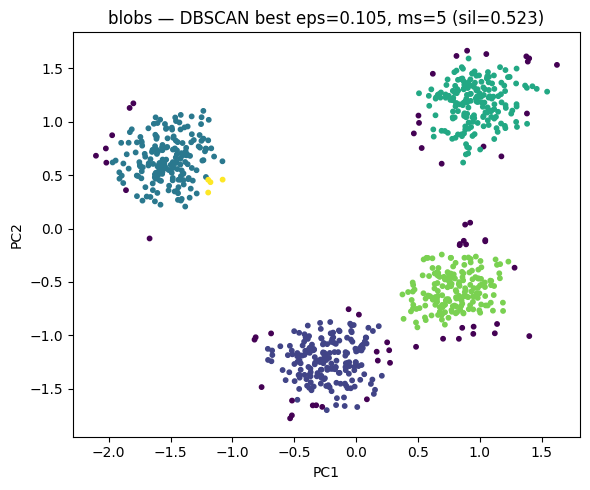

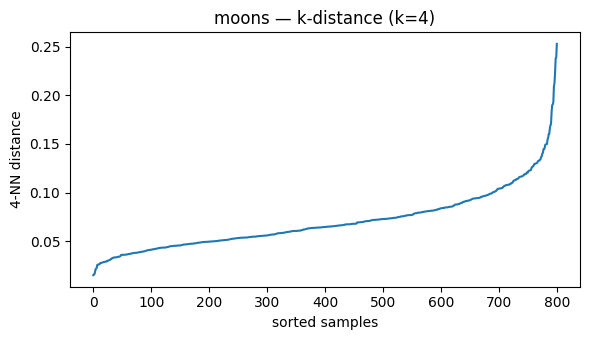

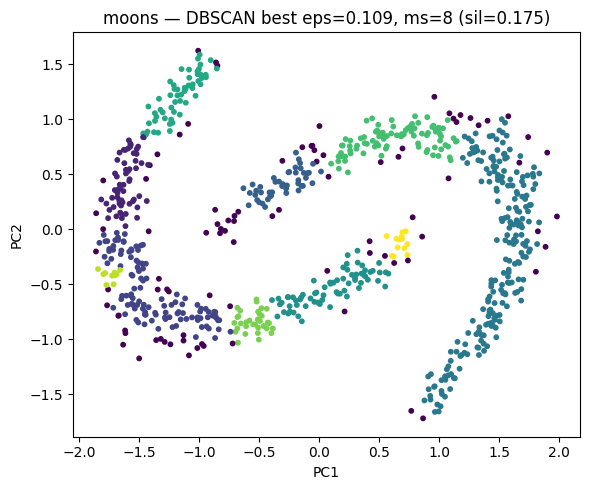

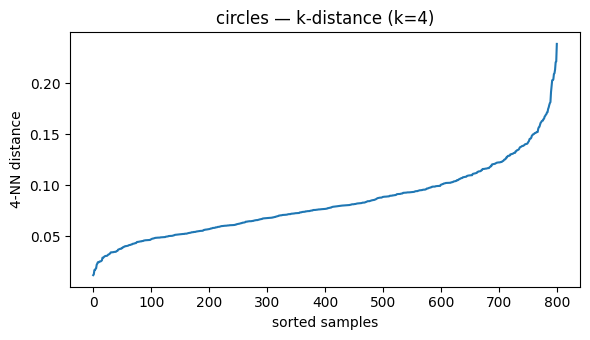

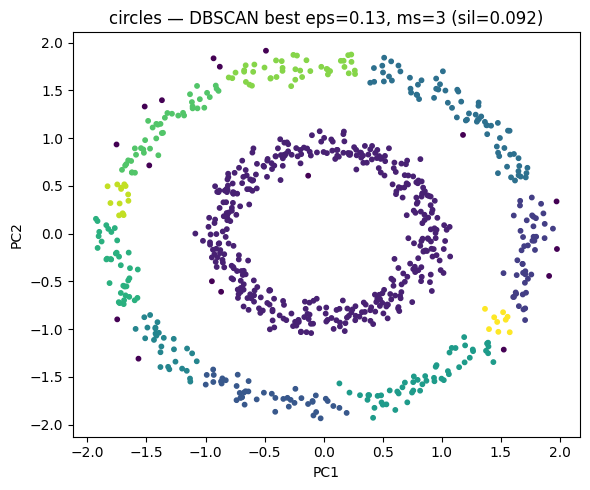

,eps,min_samples,sil,db,ch,dataset
25,0.105,5,0.522905,1.474741,1197.181653,blobs
26,0.105,8,0.428704,1.346241,629.951520,blobs
24,0.105,3,0.353220,1.370212,1160.305107,blobs
23,0.091,8,0.349304,1.518789,418.461124,blobs
21,0.091,3,0.320340,1.379081,888.210330,blobs
22,0.091,5,0.253128,1.324322,490.281370,blobs
20,0.078,8,0.075910,1.253015,172.492372,blobs
19,0.078,5,0.068262,1.436234,273.641714,blobs
18,0.078,3,0.000495,1.314091,259.884922,blobs
16,0.064,5,-0.040732,1.196561,106.223497,blobs


Mentve: /Users/adombence/Projects/clustering-playground/results/tables/dbscan.csv


In [ ]:
all_rows = []

for name, (X, y, k) in datasets.items():
    # 5.1 — k-distance plot gyors vizuális tipphez
    kdist = k_distance_plot(X, k=4, title=f"{name} — k-distance")
    
    # Javított eps rács: szélesebb tartomány több kvantilissel
    q = np.quantile(kdist, [0.3, 0.5, 0.7, 0.9])
    eps_grid = np.unique(np.round(np.concatenate([
        np.linspace(q[0], q[1], 5),
        np.linspace(q[1], q[3], 5)
    ]), 3))

    # 5.2 — sweep
    df = dbscan_sweep(X, eps_grid, min_samples_values=(3,5,8))
    df["dataset"] = name
    all_rows.append(df)

    # 5.3 — best beállítás kiválasztása silhouette szerint
    df_valid = df.dropna(subset=["sil"])
    if df_valid.empty:
        print(f"⚠️  [{name}] Nem talált érvényes klasztert ezen a rácson (minden pont outlier). Próbálj nagyobb eps értékeket!")
    else:
        best = df_valid.sort_values("sil", ascending=False).iloc[0]
        labels = DBSCAN(eps=float(best["eps"]), min_samples=int(best["min_samples"])) \
                    .fit_predict(StandardScaler().fit_transform(X))
        pca_scatter(X, labels, f"{name} — DBSCAN best eps={best['eps']}, ms={int(best['min_samples'])} (sil={best['sil']:.3f})")

df_all = pd.concat(all_rows, ignore_index=True)
display(df_all.sort_values(["dataset","sil"], ascending=[True, False]).head(15))

project_root = os.path.abspath("..")
os.makedirs(os.path.join(project_root, "results", "tables"), exist_ok=True)
out_path = os.path.join(project_root, "results", "tables", "dbscan.csv")

df_all.to_csv(out_path, index=False)